In [3]:
import skmob
import osmnx as ox

### Loading input files...

- some_trajectories_in_Rome is a TrajDataFrame with a little sample of trajectories of some vehicles moving in the center of Rome;
- modelli_auto contains the vehicles' information from which the fuel_type will be extracted;
- emission_functions contains the values for the emission functions
- max_interval is the maximum time interval (in seconds) that one wants between each pair of points in the trajectories;
- region is just the name of the region for which the road network is needed;
- pollutant_to_plot is one of {'CO_2', 'NO_x', 'PM', 'VOC'}

In [4]:
###### Parameters here:
path_to_input_file = './data/some_trajectories_in_Rome.json'
path_to_table_with_info_on_vehicles = './data/modelli_auto.tar.xz'
path_to_table_with_emission_functions = './data/emission_functions.csv'
max_interval = 120
region = 'Rome'
pollutant_to_plot = 'CO_2' # one of: CO_2, NO_x, PM, VOC
######

In [8]:
### Loading tdf
tdf = skmob.read(path_to_input_file)

print("Num of selected trajectories ('tid'):", len(set(tdf['tid'])))
set_of_uid_in_input = set(tdf['uid'])
num_of_uid_in_input = len(set_of_uid_in_input)
print("Num of vehicles ('uid'):", num_of_uid_in_input)
tdf.drop(['tile_ID'], axis=1).head()  # (dropping column 'tileID', not needed here)

Num of selected trajectories ('tid'): 1087
Num of vehicles ('uid'): 68


,uid,tid,lat,lng,datetime
122384,116559,109,41.889132,12.491207,2017-02-19 16:12:02
122814,116559,203,41.896708,12.487090,2017-04-07 19:26:22
122815,116559,204,41.896708,12.487090,2017-04-08 00:11:12
122816,116559,204,41.897440,12.495395,2017-04-08 00:18:37
122858,116559,214,41.897116,12.484191,2017-04-12 17:00:23


### Filtering...

#### 1. on time: 
    this retains only sub-trajectories composed by points that are distant not more than max_interval (in seconds) from each other;

In [9]:
from filtering import *

tdf_filtered_time = filter_on_time_interval(tdf, max_interval)

#### 2. on speed: 
    this retains only points that have a value of speed not greater than max_speed_kmh;

In [10]:
from skmob.preprocessing import filtering

tdf_filtered_speed = filtering.filter(tdf_filtered_time, max_speed_kmh = 300)

#### 3. on acceleration: 
    this retains only points that have a value of acceleration not greater than 10 m/s^2;

In [11]:
from speed_and_acceleration import *

tdf_with_speed_and_acc = compute_acceleration_from_tdf(tdf_filtered_speed)
ftdf = tdf_with_speed_and_acc[tdf_with_speed_and_acc['acceleration'] < 10]

In [12]:
set_of_uid_final = set(ftdf['uid'])
num_of_uid_final = len(set_of_uid_final)
print('There have been', num_of_uid_in_input-num_of_uid_final, "'uid' lost in the filtering process.")
ftdf.head(9)

There have been 57 'uid' lost in the filtering process.


,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000


### Loading the road network...

In [13]:
''' (This takes a bit longer...)
region_name = region.lower().replace(" ", "_")
road_network = ox.graph_from_place(region, network_type = 'drive_service')
'''

# Taking a little road network centered in Piazza Venezia, Rome:
road_network = ox.graph_from_point((41.895947, 12.483000), distance=1500, network_type = 'drive_service') # Roma (centered on Piazza Venezia)

### Map-matching...

In [14]:
from map_matching import *

ftdf_final = find_nearest_edges_in_network(road_network, ftdf, return_tdf_with_new_col=True)
ftdf_final.head(9)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000,"[1107548553, 25419843]"
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000,"[1107548553, 25419843]"
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000,"[246144912, 246144858]"
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000,"[246144912, 246144858]"
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000,"[246142109, 25418929]"
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000,"[246142109, 25418929]"
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028,"[246142109, 25418929]"
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488,"[246142109, 25418929]"
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000,"[269277049, 32650405]"


### Computing emissions...

- loading information on fuel types and emission functions:

In [15]:
from emissions import *
import tarfile

tar = tarfile.open(path_to_table_with_info_on_vehicles, "r:xz")
for x in tar.getmembers():
    file = tar.extractfile(x)
    modelli_auto = pd.read_csv(file, names=['vid', 'manufacturer', 'type'], usecols = [0,1,2])

modelli_auto.head()

,vid,manufacturer,type
0,1,PEUGEOT,106 106 954I CAT 3 PORTE XN
1,2,FIAT,SEICENTO SEICENTO
2,3,FIAT,SEICENTO SEICENTO
3,4,MINI,MINI COUNTRYMAN R60 MINI 2.0 COOPER D COUNTRYM...
4,5,FIAT,SEICENTO SEICENTO 1.1I CAT SPORTING


In [16]:
emissions = pd.read_csv(path_to_table_with_emission_functions)

- from modelli_auto, selecting only the vehicles that are in our filtered tdf:

In [17]:
df_vehicles_info = modelli_auto.loc[modelli_auto['vid'].isin(set_of_uid_final)]

- matching each of the selected vehicle with its fuel type:

In [18]:
dict_vehicle_fuel_type = match_vehicle_to_fuel_type(ftdf_final, modelli_auto, ['PETROL', 'DIESEL', 'LPG'])

- finally computing emissions:

In [19]:
tdf_with_emissions = compute_emissions(ftdf_final, emissions, dict_vehicle_fuel_type)
tdf_with_emissions.head(9)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link,NO_x,CO_2,PM,VOC
0,21495,2455,41.892054,12.472375,2017-06-29 05:03:56,1390,0.00000,0.000000,"[1107548553, 25419843]",0.000619,0.553000,0.000000,0.00447
1,21495,2455,41.892054,12.472375,2017-06-29 05:04:12,1390,0.00000,0.000000,"[1107548553, 25419843]",0.000619,0.553000,0.000000,0.00447
2,21969,2660,41.892437,12.493278,2017-04-22 15:02:43,1507,0.00000,0.000000,"[246144912, 246144858]",0.000619,0.553000,0.000000,0.00447
3,21969,2660,41.892437,12.493278,2017-04-22 15:02:49,1507,0.00000,0.000000,"[246144912, 246144858]",0.000619,0.553000,0.000000,0.00447
4,64156,2731,41.894576,12.492762,2017-09-23 16:20:30,1507,0.00000,0.000000,"[246142109, 25418929]",0.000619,0.553000,0.000000,0.00447
5,64156,2731,41.894576,12.492762,2017-09-23 16:21:07,1507,0.00000,0.000000,"[246142109, 25418929]",0.000619,0.553000,0.000000,0.00447
6,64156,2731,41.894540,12.492749,2017-09-23 16:21:44,1507,0.11203,0.003028,"[246142109, 25418929]",0.000627,0.571873,0.000002,0.00447
7,64156,2731,41.894616,12.492765,2017-09-23 16:22:20,1507,0.23761,0.003488,"[246142109, 25418929]",0.000636,0.592178,0.000004,0.00447
8,92821,2709,41.887217,12.484794,2017-04-24 17:31:42,1448,0.00000,0.000000,"[269277049, 32650405]",0.000619,0.553000,0.000000,0.00447


### Plotting results...

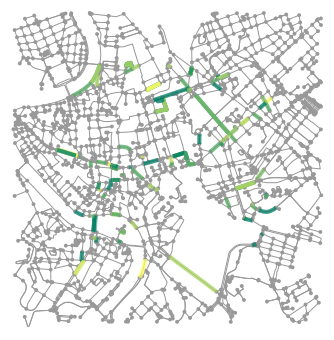

In [20]:
from plot import *

fig, ax = plot_road_network_with_emissions(tdf_with_emissions, road_network, 
                                           name_of_pollutant = pollutant_to_plot, save_fig=False)